In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Loading data

Data can be downloaded as a `zip` file at https://drive.google.com/file/d/1h0ThrK252cyeJr4TwkqQCNKJhGMji-4B/view?usp=sharing

It contains the following files:
- `newspapers.jsonl` 190MB, 100 000 articles 
- `newspapers_sample.jsonl` 200KB, 100 articles

Extract them to the project's root directory.

JSONL is a file format that contains a sequence of JSON objects, each object in a separate line.

In [42]:
from json import loads, dumps

data_sample = [
    loads(line) for line in open('data/newspapers_sample.jsonl', 'r', encoding='utf-8').readlines()
]

data = [
    loads(line) for line in open('data/newspapers.jsonl', 'r', encoding='utf-8').readlines()
]

data_sample[:3]

[{'text': 'On ne s’attendait pas du tout à trouver une ville aussi jolie entourée de remparts. » La surprise émerveille plus d’un touriste, qu’il soit français ou étranger, quand il découvre Angoulême. Le Plateau et ses ruelles surprennent. Et surtout séduisent. Notamment les étrangers dont on fête le grand retour, cette année, après deux étés de disette en raison de la crise sanitaire.\n\nBelges, Britanniques et Néerlandais constituent le hit de parade des nationalités représentées depuis début juillet. On croise également des Espagnols, des Italiens et quelques Nord-Américains. Et même des Danois, accueillis pour la première fois au Musée d’art et d’histoire de la ville. « Peut-être grâce au Tour de France ! », avance-t-on dans un sourire à l’accueil.\n\nLes Anglo-Saxons et les vieilles pierres\n\nDifficile de dire si le label « Ville créative », délivré par l’Unesco fin 2019, pèse sur la venue d’étrangers dans la ville. Peu semblent au courant de cette reconnaissance. S’ils s’arrête

### Fields

What are the fields of the JSON objects?

In [43]:
keys = {key for item in data for key in item.keys()}
keys

{'article', 'date', 'text', 'title'}

### Transform the json objects in dataframes

In [44]:
df = pd.DataFrame(data)
df_sample = pd.DataFrame(data_sample)


### Any missing values?  (No)

In [46]:
df.isnull().sum()

text       0
title      0
date       0
article    0
dtype: int64

# Duplicates

Are there any duplicates in the data? If so, how many?

In [5]:
# Drop duplicate rows : 
df.drop_duplicates(inplace=True)
len(df)

100000

Each row is unique. But there can be multiple articles with the same title for instance. 

#TODO : check the duplicates for each column

In [38]:
df[['title', 'text', 'date', 'article']].describe()

,title,text,date,article
count,99962,99962,99962,99962
unique,99013,86532,675,99962
top,Vosges. Notre édition numérique est en ligne,"Pourtant, comme les abonnements, ils permetten...",2022-03-11T00:00:00.000,2047761 at https://france3-regions.francetvinf...
freq,40,2337,321,1


# Lengths of titles and texts

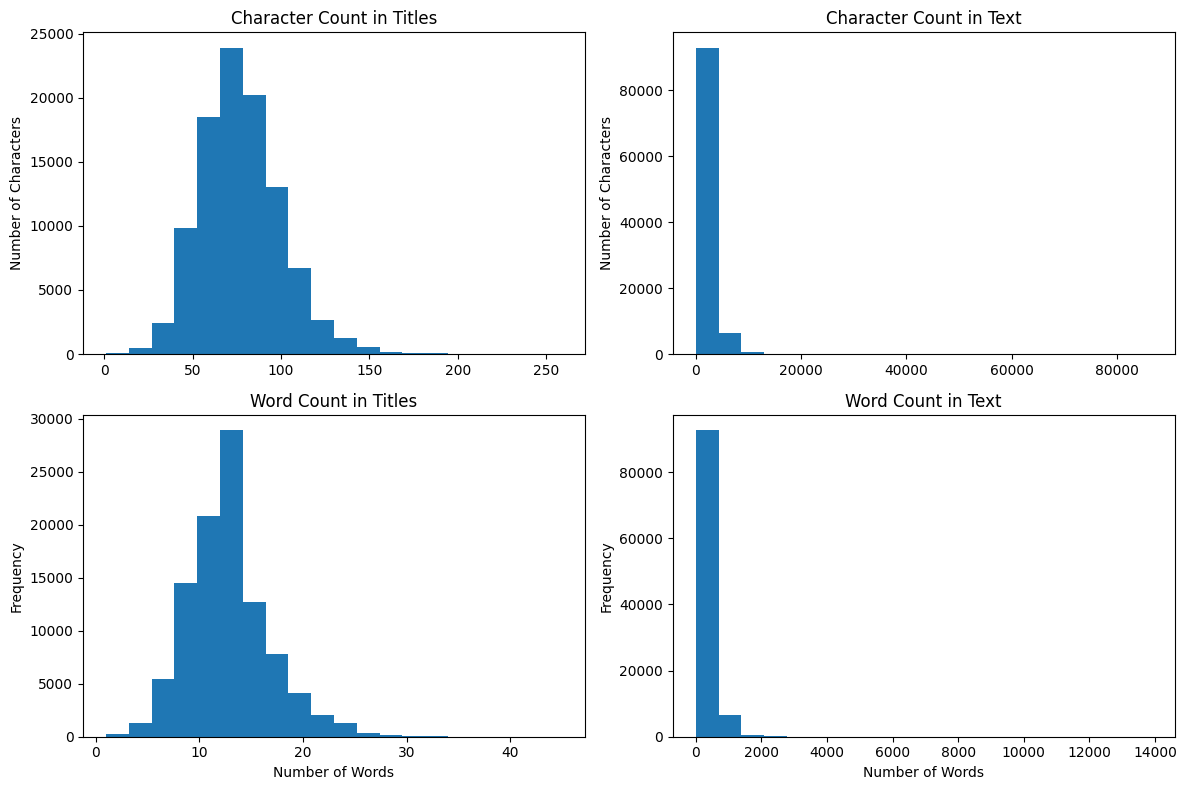

In [6]:
# Calculate the number of characters in titles and text
df['title_char_count'] = df['title'].str.len()
df['text_char_count'] = df['text'].str.len()

# Calculate the number of words in titles and text
df['title_word_count'] = df['title'].str.split().str.len()
df['text_word_count'] = df['text'].str.split().str.len()

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplot of character count in titles
axs[0, 0].hist(df['title_char_count'], bins=20)
axs[0, 0].set_title('Character Count in Titles')
axs[0, 0].set_ylabel('Number of Characters')

# Boxplot of character count in text
axs[0, 1].hist(df['text_char_count'], bins=20)
axs[0, 1].set_title('Character Count in Text')
axs[0, 1].set_ylabel('Number of Characters')

# Histogram of word count in titles
axs[1, 0].hist(df['title_word_count'], bins=20)
axs[1, 0].set_title('Word Count in Titles')
axs[1, 0].set_xlabel('Number of Words')
axs[1, 0].set_ylabel('Frequency')

# Histogram of word count in text
axs[1, 1].hist(df['text_word_count'], bins=20)
axs[1, 1].set_title('Word Count in Text')
axs[1, 1].set_xlabel('Number of Words')
axs[1, 1].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
# Show the longuest titles
longuest_titles = df.sort_values('title_char_count', ascending=False).head(200)

longuest_titles[['title', 'title_char_count']]


,title,title_char_count
42978,L'essentiel du sport dans nos régions. Antoine...,259
48421,En image | ddddddddddddddddddddddddddddddddddd...,249
28621,"La Suédoise Linn Grant regarde son drive, au d...",248
91553,La Matinale. Pierre Palmade gravement blessé d...,245
27317,L'essentiel du sport dans nos régions. Premier...,238
...,...,...
99320,Des naturalistes d'Alsace Bossue mobilisés con...,165
11647,Mâcon (communiqué ). La commission des finance...,165
77353,"Disparition d'Alex Batty : ""Il nous accompagna...",165
16987,Un 47eme fourgon d'intervention percuté sur l'...,165


### Repeating characters

- We found the text `dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddeeeeeeeeeeeeeeeeeeeePose`in a title.
  It might be useful to count the number of repeating characters in the text.

In [9]:
def count_repeating_chars(text:str)->int:
    """Count the number of repeating characters in a string.
    
    Example:
    count_repeating_chars('aab') -> 1
    count_repeating_chars('aaabb') -> 3
    """
    count = 0
    for i in range(1, len(text)):
        if text[i] == text[i-1]:
            count += 1
    return count

assert count_repeating_chars('aab') == 1
assert count_repeating_chars('aaabb') == 3

In [10]:
def count_repeating_non_whitespace_chars(text:str)->int:
    """Count the number of repeating non-whitespace characters in a string.
    
    Example:
    count_repeating_non_whitespace_chars('aab') -> 1
    count_repeating_non_whitespace_chars('aaabb') -> 3
    count_repeating_non_whitespace_chars('aa a') -> 2
    """
    text = text.replace(' ', '').replace('\n', '').replace('\t', '').replace('\r', '')
    return count_repeating_chars(text)

assert count_repeating_non_whitespace_chars('aab') == 1
assert count_repeating_non_whitespace_chars('aaabb') == 3
assert count_repeating_non_whitespace_chars('aa a') == 2

Only counting the number of repeating characters in the text would penalize long texts. We should normalize this number by the length of the text.

In [11]:
# Count repeating characters in titles and text and dividing by the number of characters

df['title_repeating_chars'] = df['title'].apply(count_repeating_non_whitespace_chars) / df['title_char_count']
df['text_repeating_chars'] = df['text'].apply(count_repeating_non_whitespace_chars) / df['text_char_count']

In [12]:
# Show the rows with the highest ratio of repeating characters in titles
df.sort_values('title_repeating_chars', ascending=False).head(10)[['title', 'title_repeating_chars']]

,title,title_repeating_chars
48421,En image | ddddddddddddddddddddddddddddddddddd...,0.510040
34828,ZOOM,0.250000
16286,495 000 €,0.222222
9521,XXXXXXXXX. Une législation qui évolue en perma...,0.176471
22558,500 à sillonner le terroir,0.153846
73655,Comment placer 50 000 euros,0.148148
82484,Halloween en familles,0.142857
12681,Football. ASSE : le successeur de Laurent Batl...,0.121212
63319,On a testé...l'attelage !,0.120000
52597,Un football lorrain au fort accent polonais,0.116279


In [13]:
# Same for text
df.sort_values('text_repeating_chars', ascending=False).head(10)[['title', 'text', 'text_repeating_chars']]

,title,text,text_repeating_chars
48421,En image | ddddddddddddddddddddddddddddddddddd...,En image | ddddddddddddddddddddddddddddddddddd...,0.414791
56337,Confolens : Le prix Abel Desaphy disputé jeudi,"Pour les épreuves d’école de vélo, les dossard...",0.314079
92943,Football : découvrez les affiches du 5e tour d...,????? ?? ?????? : ???????? ?? ?? ???? \ud83c\u...,0.235808
26287,Aveyron : suivez le week-end de sports en direct,"Football, basket-ball, handball, moto ou encor...",0.205108
73389,"Football, basket-ball, handball : suivez les r...",Suivez ci-dessous l'avancée des résultats spor...,0.175405
27180,"Football, handball, trail : retrouvez tous les...",Retrouvez ci-dessous l'ensemble des résultats ...,0.135633
95416,"Rugby, football, basket-ball : suivez en direc...","Football, rugby à XIII et à XV, handball, bask...",0.119357
64024,"Football, auto, basket-ball : suivez en direct...","Football, rugby à XIII, handball, automobile.....",0.101159
55529,"Basket-ball, rugby, football : découvrez tous ...","Basket-ball, football, handball, rugby....Retr...",0.100370
81783,"Football, basket-ball, rugby : le Sporting dec...","Football, rugby à XIII et à XV, handball, cour...",0.093532


Turns out the only problematic text is the one mentioned above.

In [14]:
# Drops rows having a title with more than 0.50 repeating characters score
df = df[df['title_repeating_chars'] < 0.50]

### Looking at the shortests titles

In [16]:
df.sort_values('title_char_count').head(10)[['title', 'title_char_count', 'text']]

,title,title_char_count,text
59191,8,1,"...pour lire la suite, rejoignez notre communa..."
85033,164,3,"164\n\nC’est en millions d’euros, la somme des..."
43755,"3,38",4,"en millions d’euros, c’est le montant de l’env..."
34828,ZOOM,4,ZOOM\n\nPar Le Progrès - Hier à 18:37 - Temps ...
62470,L'Ouïe,6,Entendre c’est aussi se donner le temps d’appr...
87771,Vite lu,7,Arbres abattus avenue du 8-Mai-1945. Les agent...
92692,➤ Voir,7,➤ Voir\n\nPar Le Bien Public - Aujourd'hui à 1...
49896,Vite lu,7,Concert avec dimanche avec Franck Besingrand. ...
2078,Repères,7,Repères\n\nPar Le Dauphiné Libéré - Aujourd'hu...
6891,contexte,8,"...pour lire la suite, rejoignez notre communa..."


We will look at titles which only consist of numbers

In [21]:
import string

FRENCH_LETTERS = string.ascii_letters + 'àâçéèêëîïôûüÿæœ'
FRENCH_LETTERS

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZàâçéèêëîïôûüÿæœ'

In [24]:
def get_only_alpha_text(text:str, alphabset_set=FRENCH_LETTERS)->str:
    """Return a string containing only the letters of the input string.

    Example:
    get_only_alpha_text("Hello, world 23,1!") -> "Helloworld"
    """
    return ''.join([c for c in text if c in alphabset_set])

assert get_only_alpha_text("Hello, world 23,1!") == "Helloworld"

In [26]:
# Create a new column with only the letters of the title

df['title_alpha'] = df['title'].apply(get_only_alpha_text)

# Create a new column with the number of chars in title_alpha

df['title_alpha_char_count'] = df['title_alpha'].str.len()

# Show the rows with the shortest title_alpha
df.sort_values('title_alpha_char_count').head(100)[['title', 'title_alpha', 'title_alpha_char_count']]



,title,title_alpha,title_alpha_char_count
16286,495 000 €,,0
43755,"3,38",,0
59191,8,,0
85033,164,,0
34828,ZOOM,ZOOM,4
92692,➤ Voir,Voir,4
7534,Manom. 70,Manom,5
32818,24 avril 2023,avril,5
62470,L'Ouïe,LOuïe,5
87771,Vite lu,Vitelu,6


We remove the rows having titles with less than 10 alpha characters

In [32]:
# We remove the rows having titles with less than 10 alpha characters
before_len = len(df)
df = df[df['title_alpha_char_count'] >= 10]
after_len = len(df)

print(f"Removed {before_len - after_len} rows")

Removed 37 rows


# Removing cookies banners, paywalls, and other non-content text

In [ ]:
"Pour lire la suite"
"cookie"
"abonnez-vous"
"connexion"
"inscrivez-vous"
"connectez-vous"


"""
Text: ...pour lire la suite, rejoignez notre communauté d'abonnés

et accédez à l'intégralité de nos articles sur le site et l'application mobile

Je découvre

à partir de 1 € le 1er mois, sans engagement de durée
"""

"""
et accédez à l'intégralité de nos articles sur le site et l'application mobile
"""



# Data analysis : 
## Title / Text
    Unique words
    Most common words
    Word cloud
    Html tags ? 
## Text
    Looking at very long texts
## Date
    Min and max
    Distribution
    distribution per year/ month, day. (e.g Show which weekdays are the most popular)

## article

In [ ]:
# Url validation